In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [2]:
url='http://nagyvofely.hu/Budapest/irszam'
res = requests.get(url)
res = BeautifulSoup(res.content,'lxml')

data = res.findAll('fieldset')

In [3]:
postal_code=[d.find('a').text for d in data]
district=[d.find('a')['title'].replace(' ', '').split(',')[1].split('.')[0] for d in data]

In [4]:
df=pd.DataFrame()
df['PostalCode']=postal_code
df['Neighborhood']=district
df.tail(10)

,PostalCode,Neighborhood
151,1214,XXI
152,1215,XXI
153,1221,XXII
154,1222,XXII
155,1223,XXII
156,1224,XXII
157,1225,XXII
158,1237,XXIII
159,1238,XXIII
160,1239,XXIII


In [ ]:
url_temp='https://xn--irnytszmok-t4af6mnd.cybo.com/magyarorsz%C3%A1g/postal_budapest-x.-ker%C3%BClet/'

lat=[]
lon=[]
latlon=pd.DataFrame()

for postal in df['PostalCode'][0:9]:
    url=url_temp.replace('postal', str(postal))

    res = requests.get(url, headers=headers)
    res = BeautifulSoup(res.content,'lxml')
    tables=res.findAll('table')
    if(len(tables)!=0):
        table=tables[0]
        rows=table.findAll('tr')

        for r in rows:
            cells=r.findAll('td')
            if cells[0].text=='Koordináták':
                coords=cells[1].text.split('/')
                lat.append(coords[0].replace('°','').replace(' ', ''))
                lon.append(coords[1].replace('°','').replace(' ',''))
    else:
        print(postal)

In [ ]:
df['Borough.Latitude']=lat
df['Borough.Longitude']=lon
df.head()

In [5]:
url='https://en.m.wikipedia.org/wiki/List_of_districts_in_Budapest'

#res=requests.get(url)
#res=BeautifulSoup(res.content, 'lxml')
#table=res.find('table')
df2=pd.read_html(url, skiprows=1)[0]
df2.head()

,0,1,2,3
0,I.,Várkerület(Castle District),"Buda Castle, Tabán, Gellérthegy, Krisztinaváro...","Buda Castle, Matthias Church, Hungarian Nation..."
1,II.,none,"Adyliget, Budakeszierdő, Budaliget, Csatárka, ...","Tomb of Gül Baba, Mechwart Park, Cave of Szeml..."
2,III.,Óbuda-Békásmegyer,"Óbuda, Aquincum, Aranyhegy, Békásmegyer, Csill...","Ruins of Aquincum, Aquincum Military Amphithea..."
3,IV.,Újpest(New Pest),"Újpest, Megyer, Káposztásmegyer, Székesdűlő, I...","Queen of Heavens Church, Synagogue of Újpest, ..."
4,V.,Belváros-Lipótváros(Inner City-Leopold Town),"Inner City, Lipótváros","Parliament, Hungarian Academy of Sciences, Gre..."


In [6]:
df3=pd.DataFrame() 
df3['Neighborhood']=df2[0].apply(lambda x: x.replace('.','').replace(' kerület',''))
df3['Borough']=df2[2]
df3.drop(df3.index[-1], inplace=True)
df3.head()

,Neighborhood,Borough
0,I,"Buda Castle, Tabán, Gellérthegy, Krisztinaváro..."
1,II,"Adyliget, Budakeszierdő, Budaliget, Csatárka, ..."
2,III,"Óbuda, Aquincum, Aranyhegy, Békásmegyer, Csill..."
3,IV,"Újpest, Megyer, Káposztásmegyer, Székesdűlő, I..."
4,V,"Inner City, Lipótváros"


In [7]:
coords='47.4979° N, 19.0402° E, 47.5393° N, 18.9869° E, 47.5672° N, 19.0369° E, 47.5649° N, 19.0913° E, 47.5002° N, 19.0520° E, 47.5099° N, 19.0626° E, 47.5027° N, 19.0734° E, 47.4894° N, 19.0707° E, 47.4649° N, 19.0916° E, 47.4833° N, 19.1573° E, 47.4593° N, 19.0187° E, 47.4991° N, 18.9905° E, 47.5355° N, 19.0709° E, 47.5225° N, 19.1147° E, 47.5589° N, 19.1193° E, 47.5183° N, 19.1919° E, 47.4803° N, 19.2667° E, 47.4281° N, 19.2098° E, 47.4457° N, 19.1430° E, 47.4333° N, 19.1193° E, 47.4244° N, 19.0661° E, 47.4250° N, 19.0317° E, 47.3940° N, 19.1225° E'
coords=coords.replace('° E', '').replace('° N', '').split(', ')
df3['Neighborhood.Latitude']=coords[::2]
df3['Neighborhood.Longitude']=coords[1::2]
df3

,Neighborhood,Borough,Neighborhood.Latitude,Neighborhood.Longitude
0,I,"Buda Castle, Tabán, Gellérthegy, Krisztinaváro...",47.4979,19.0402
1,II,"Adyliget, Budakeszierdő, Budaliget, Csatárka, ...",47.5393,18.9869
2,III,"Óbuda, Aquincum, Aranyhegy, Békásmegyer, Csill...",47.5672,19.0369
3,IV,"Újpest, Megyer, Káposztásmegyer, Székesdűlő, I...",47.5649,19.0913
4,V,"Inner City, Lipótváros",47.5002,19.0520
5,VI,Terézváros,47.5099,19.0626
6,VII,Erzsébetváros,47.5027,19.0734
7,VIII,"Józsefváros, Kerepesdűlő, Tisztviselőtelep",47.4894,19.0707
8,IX,"Ferencváros, Gubacsidűlő, József Attila-lakótelep",47.4649,19.0916
9,X,"Felsőrákos, Gyárdűlő, Keresztúridűlő, Kőbánya-...",47.4833,19.1573


In [8]:
merged = pd.merge(left=df3, right=df, left_on='Neighborhood', right_on='Neighborhood')
merged.tail()

,Neighborhood,Borough,Neighborhood.Latitude,Neighborhood.Longitude,PostalCode
156,XXII,"Budatétény, Nagytétény, Budafok",47.4250,19.0317,1224
157,XXII,"Budatétény, Nagytétény, Budafok",47.4250,19.0317,1225
158,XXIII,Soroksár,47.3940,19.1225,1237
159,XXIII,Soroksár,47.3940,19.1225,1238
160,XXIII,Soroksár,47.3940,19.1225,1239


In [9]:
!pip install folium
import folium

     |████████████████████████████████| 102kB 12.7MB/s ta 0:00:01


In [10]:
bp_lat='47.48'
bp_lon='19.13'

line_points=[
    (47.3850,19.0320),
    (47.5850,19.0580)
]

map=folium.Map(location=[bp_lat, bp_lon], zoom_start=11)

folium.PolyLine(line_points, color='blue', weight=5, opacity=1).add_to(map)

folium.map.Marker(
    [47.5850, 19.0200],
    icon=folium.DivIcon(
        icon_size=(15,15),
        icon_anchor=(0,0),
        html='<b style="font-size: 16pt;">Buda</b>'
        )
    ).add_to(map)
folium.map.Marker(
    [47.5850, 19.0600],
    icon=folium.DivIcon(
        icon_size=(15,15),
        icon_anchor=(0,0),
        html='<b style="font-size: 16pt;">Pest</b>',
        )
    ).add_to(map)

for lat, lon, label in zip(df3['Neighborhood.Latitude'], df3['Neighborhood.Longitude'], df3['Neighborhood']):
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon], 
        radius=5,
        color='red',
        popup=label,
        fill=True,
        fill_color='#500000',
        fill_opacity=0.7,
        parse_html=False).add_to(map)

map

In [11]:
# The code was removed by Watson Studio for sharing.

In [12]:
CLIENT_ID='YOUR_ID'
CLIENT_SECRET='YOUR_SECRET'
VERSION='20180605'
LIMIT=300
RADIUS=1000

In [13]:
# The code was removed by Watson Studio for sharing.

In [14]:
def getNearbyVenues(names, lats, lons):
    list=[]
    for n, la, lo in zip(names, lats, lons):
        url= 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, la, lo, RADIUS, LIMIT)
        results= requests.get(url).json()['response']['groups'][0]['items']
        list.append([(
         n, 
         la, 
         lo, 
         v['venue']['name'], 
         v['venue']['location']['lat'], 
         v['venue']['location']['lng'], 
         v['venue']['categories'][0]['name']) for v in results]
        )
    
    nearby=pd.DataFrame([item for vlist in list for item in vlist])
    nearby.columns=[
     'Neighborhood',
     'Neighborhood Latitude', 
     'Neighborhood Longitude',
     'Venue',
     'Venue Latitude',
     'Venue Longitude', 
     'Venue Category'
    ]

    return(nearby)

In [15]:
venues=getNearbyVenues(
  names=df3['Neighborhood'],
  lats=df3['Neighborhood.Latitude'],
  lons=df3['Neighborhood.Longitude']
)
print(venues.shape)

(1155, 7)


In [16]:
onehot=pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")
onehot['Neighborhood']=venues['Neighborhood']
fixed_columns=[onehot.columns[-1]]+list(onehot.columns[:-1])
onehot=onehot[fixed_columns]
grouped=onehot.groupby('Neighborhood').mean().reset_index()
print(grouped.shape)

(23, 219)


In [17]:
def most_common_venues(row, top):
    row_categories=row.iloc[1:]
    row_categories_sorted= row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:top]

In [18]:
import numpy as np

In [19]:
top=10
indicators=['st', 'nd', 'rd']
columns=['Neighborhood']
for ind in np.arange(top):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicator[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

sorted=pd.DataFrame(columns=columns)
sorted['Neighborhood']=grouped['Neighborhood']

for ind in np.arange(grouped.shape[0]):
    sorted.iloc[ind, 1:]=most_common_venues(grouped.iloc[ind, :],top)

sorted.head()

,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,I,Hotel,Coffee Shop,Hungarian Restaurant,Plaza,Scenic Lookout,Pub,Bistro,Historic Site,Park,Dessert Shop
1,II,Park,Tram Station,Tennis Court,Scenic Lookout,Athletics & Sports,Playground,Soccer Field,Campground,Forest,Bus Stop
2,III,Bus Station,Electronics Store,Bus Stop,Clothing Store,Other Repair Shop,Bakery,Heliport,Track,Train Station,Mountain
3,IV,Café,Dessert Shop,Grocery Store,Fast Food Restaurant,Bakery,Gastropub,Restaurant,Burger Joint,Tram Station,Gym / Fitness Center
4,IX,Furniture / Home Store,Soccer Field,Dance Studio,Train Station,Gym / Fitness Center,Bus Station,Tram Station,Bookstore,Supermarket,Brewery


In [20]:
from sklearn.cluster import KMeans
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

     |████████████████████████████████| 266kB 7.0MB/s eta 0:00:01


/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


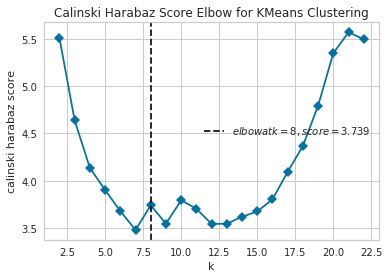

In [21]:
clustering=grouped.drop('Neighborhood', 1)

visualizer = KElbowVisualizer(KMeans(), k=(2,23), metric='calinski_harabasz', timings=False)
visualizer.fit(clustering)
visualizer.show() 

In [22]:
# The code was removed by Watson Studio for sharing.

In [23]:
k=6
kmeans=KMeans(n_clusters=k, random_state=0)
kmeans.fit(clustering)

clustered=sorted
clustered.insert(0,'Cluster Labels', kmeans.labels_)

merged=df3
merged=merged.join(sorted.set_index('Neighborhood'), on='Neighborhood')
merged

,Neighborhood,Borough,Neighborhood.Latitude,Neighborhood.Longitude,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,I,"Buda Castle, Tabán, Gellérthegy, Krisztinaváro...",47.4979,19.0402,2,Hotel,Coffee Shop,Hungarian Restaurant,Plaza,Scenic Lookout,Pub,Bistro,Historic Site,Park,Dessert Shop
1,II,"Adyliget, Budakeszierdő, Budaliget, Csatárka, ...",47.5393,18.9869,4,Park,Tram Station,Tennis Court,Scenic Lookout,Athletics & Sports,Playground,Soccer Field,Campground,Forest,Bus Stop
2,III,"Óbuda, Aquincum, Aranyhegy, Békásmegyer, Csill...",47.5672,19.0369,0,Bus Station,Electronics Store,Bus Stop,Clothing Store,Other Repair Shop,Bakery,Heliport,Track,Train Station,Mountain
3,IV,"Újpest, Megyer, Káposztásmegyer, Székesdűlő, I...",47.5649,19.0913,2,Café,Dessert Shop,Grocery Store,Fast Food Restaurant,Bakery,Gastropub,Restaurant,Burger Joint,Tram Station,Gym / Fitness Center
4,V,"Inner City, Lipótváros",47.5002,19.0520,2,Hotel,Italian Restaurant,Coffee Shop,Hungarian Restaurant,Plaza,Restaurant,Bar,Ice Cream Shop,Wine Bar,Cocktail Bar
5,VI,Terézváros,47.5099,19.0626,2,Coffee Shop,Italian Restaurant,Vietnamese Restaurant,Pizza Place,Beer Bar,Bar,Hotel,Pub,Ice Cream Shop,Indian Restaurant
6,VII,Erzsébetváros,47.5027,19.0734,2,Coffee Shop,Bar,Hotel,Hungarian Restaurant,Restaurant,Bakery,Beer Bar,Burger Joint,Bistro,Indian Restaurant
7,VIII,"Józsefváros, Kerepesdűlő, Tisztviselőtelep",47.4894,19.0707,2,Coffee Shop,Hotel,Bar,Italian Restaurant,Ice Cream Shop,Beer Bar,Wine Bar,Burger Joint,Electronics Store,Comedy Club
8,IX,"Ferencváros, Gubacsidűlő, József Attila-lakótelep",47.4649,19.0916,2,Furniture / Home Store,Soccer Field,Dance Studio,Train Station,Gym / Fitness Center,Bus Station,Tram Station,Bookstore,Supermarket,Brewery
9,X,"Felsőrákos, Gyárdűlő, Keresztúridűlő, Kőbánya-...",47.4833,19.1573,5,Tram Station,Bus Stop,Park,Fast Food Restaurant,Track,Sporting Goods Shop,Brewery,Supermarket,Bistro,Gym


In [24]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [25]:
map=folium.Map(location=[bp_lat, bp_lon], zoom_start=11)

folium.PolyLine(line_points, color='blue', weight=5, opacity=1).add_to(map)

folium.map.Marker(
    [47.5850, 19.0200],
    icon=folium.DivIcon(
        icon_size=(15,15),
        icon_anchor=(0,0),
        html='<b style="font-size: 16pt;">Buda</b>'
        )
    ).add_to(map)
folium.map.Marker(
    [47.5850, 19.0600],
    icon=folium.DivIcon(
        icon_size=(15,15),
        icon_anchor=(0,0),
        html='<b style="font-size: 16pt;">Pest</b>'
        )
    ).add_to(map)

x=np.arange(k)
ys=[i+x+(i*x)**2 for i in range(k)]
colors_array=cm.rainbow(np.linspace(0,1,len(ys)))
rainbow=[colors.rgb2hex(i) for i in colors_array]

markers_colors=[]

for lat, lon, poi, clus in zip(merged['Neighborhood.Latitude'], merged['Neighborhood.Longitude'], merged['Neighborhood'], merged['Cluster Labels']):
    label=folium.Popup(str(poi)+' Cluster '+str(clus), parse_html=True)
    folium.CircleMarker(
        [lat, lon], 
        radius=5,
        color=rainbow[clus-1], 
        popup=label,
        fill=True,
        fill_color=rainbow[clus-1], 
        fill_opacity=0.7).add_to(map)
    folium.Circle(
        [lat, lon],
        radius=RADIUS,
        color='green',  
        fill=False).add_to(map)
                                        
map

In [26]:
# The code was removed by Watson Studio for sharing.

In [27]:
merged.loc[merged['Cluster Labels']==0, merged.columns[[0]+list(range(k-1, merged.shape[1]))]]

,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,III,Bus Station,Electronics Store,Bus Stop,Clothing Store,Other Repair Shop,Bakery,Heliport,Track,Train Station,Mountain


In [28]:
merged.loc[merged['Cluster Labels']==1, merged.columns[[0]+list(range(k-1, merged.shape[1]))]]

,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,XI,Bus Stop,Bakery,Platform,Smoke Shop,Grocery Store,Hungarian Restaurant,Pub,Dessert Shop,Dog Run,Bus Station
11,XII,Bus Stop,Hungarian Restaurant,Platform,Scenic Lookout,Coffee Shop,Garden,Bus Station,Forest,Sculpture Garden,Eastern European Restaurant
16,XVII,Bus Stop,Pharmacy,Train Station,Grocery Store,Optical Shop,Burger Joint,Café,Carpet Store,Chinese Restaurant,Farmers Market
21,XXII,Bus Stop,Bakery,Pharmacy,Tram Station,Playground,Plaza,Go Kart Track,Stadium,Café,Food & Drink Shop


In [29]:
merged.loc[merged['Cluster Labels']==2, merged.columns[[0]+list(range(k-1, merged.shape[1]))]]

,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,I,Hotel,Coffee Shop,Hungarian Restaurant,Plaza,Scenic Lookout,Pub,Bistro,Historic Site,Park,Dessert Shop
3,IV,Café,Dessert Shop,Grocery Store,Fast Food Restaurant,Bakery,Gastropub,Restaurant,Burger Joint,Tram Station,Gym / Fitness Center
4,V,Hotel,Italian Restaurant,Coffee Shop,Hungarian Restaurant,Plaza,Restaurant,Bar,Ice Cream Shop,Wine Bar,Cocktail Bar
5,VI,Coffee Shop,Italian Restaurant,Vietnamese Restaurant,Pizza Place,Beer Bar,Bar,Hotel,Pub,Ice Cream Shop,Indian Restaurant
6,VII,Coffee Shop,Bar,Hotel,Hungarian Restaurant,Restaurant,Bakery,Beer Bar,Burger Joint,Bistro,Indian Restaurant
7,VIII,Coffee Shop,Hotel,Bar,Italian Restaurant,Ice Cream Shop,Beer Bar,Wine Bar,Burger Joint,Electronics Store,Comedy Club
8,IX,Furniture / Home Store,Soccer Field,Dance Studio,Train Station,Gym / Fitness Center,Bus Station,Tram Station,Bookstore,Supermarket,Brewery
12,XIII,Coffee Shop,Gym / Fitness Center,Grocery Store,Pub,Electronics Store,Indian Restaurant,Park,Supermarket,Diner,Fast Food Restaurant
13,XIV,Bus Stop,Chinese Restaurant,Ice Cream Shop,Dessert Shop,Bakery,Plaza,Gym / Fitness Center,Pharmacy,Restaurant,Pizza Place
20,XXI,Grocery Store,Beer Garden,Gym,Fast Food Restaurant,Restaurant,Electronics Store,Soccer Field,Gym / Fitness Center,Bar,Clothing Store


In [30]:
merged.loc[merged['Cluster Labels']==3, merged.columns[[0]+list(range(k-1, merged.shape[1]))]]

,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,XXIII,Dessert Shop,Cosmetics Shop,Park,Grocery Store,Bakery,Light Rail Station,Train Station,River,Hungarian Restaurant,Bus Stop


In [31]:
merged.loc[merged['Cluster Labels']==4, merged.columns[[0]+list(range(k-1, merged.shape[1]))]]

,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,II,Park,Tram Station,Tennis Court,Scenic Lookout,Athletics & Sports,Playground,Soccer Field,Campground,Forest,Bus Stop


In [32]:
merged.loc[merged['Cluster Labels']==5, merged.columns[[0]+list(range(k-1, merged.shape[1]))]]

,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,X,Tram Station,Bus Stop,Park,Fast Food Restaurant,Track,Sporting Goods Shop,Brewery,Supermarket,Bistro,Gym
14,XV,Bus Stop,Grocery Store,Clothing Store,Gym,Soccer Stadium,Pet Store,Shoe Store,Supermarket,Tanning Salon,Restaurant
15,XVI,Bus Stop,Gym / Fitness Center,Grocery Store,Light Rail Station,Cupcake Shop,Pizza Place,Soccer Stadium,Smoke Shop,Restaurant,Plaza
17,XVIII,Bus Stop,Grocery Store,Tram Station,Park,Pool Hall,Dessert Shop,Supermarket,Eastern European Restaurant,Bakery,Gym / Fitness Center
18,XIX,Bus Stop,Grocery Store,Tram Station,Park,Liquor Store,Salon / Barbershop,Deli / Bodega,Ice Cream Shop,Playground,Dive Shop
19,XX,Tram Station,Bus Stop,Grocery Store,Food & Drink Shop,Bakery,Plaza,Steakhouse,Supermarket,Pharmacy,Park
